In [89]:
import matplotlib.pyplot as plt
import mat73
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from scipy.signal import butter, filtfilt, find_peaks, peak_prominences
from scipy import integrate
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
import scipy.signal as sg
from sklearn.metrics import mean_squared_error

# 数据读取

In [90]:
mat_path = 'D:\大四\FYP\cuff+less+blood+pressure+estimation'
file_name = ['Part_1','Part_4']
#暂时没用part2、3 的数据，par2、3有点奇怪

raw_PPG = []
raw_ABP = []

#遍历读取每一部分的数据，大概耗时1min
for single_mat in file_name:
    path_mat = mat_path + "\\" + single_mat +'.mat'
    mat=mat73.loadmat(path_mat)  #读取mat文件
    raw_PPG.append(mat[single_mat][0][0])
    raw_ABP.append(mat[single_mat][0][1])

raw_PPG = np.array(raw_PPG)
raw_ABP = np.array(raw_ABP)

C:\Users\Neil\AppData\Local\Temp\ipykernel_42340\3433352832.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  raw_PPG = np.array(raw_PPG)
C:\Users\Neil\AppData\Local\Temp\ipykernel_42340\3433352832.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  raw_ABP = np.array(raw_ABP)


In [91]:
#把PPG信号转化成numpy数组
PPG = np.concatenate(raw_PPG)
ABP = np.concatenate(raw_ABP)

total_time = PPG.shape[0]/125



In [158]:
print(ABP)

[67.06295517 69.35862807 75.36645289 ... 64.62074995 66.2814495
 68.43059009]


In [159]:
print('PPG的总采样数是'+str(PPG.shape[0]))
print('ABP的总采样数是'+str(ABP.shape[0]))
print('信号采样频率是125HZ')
print('信号采样时长为'+str(float(total_time/360))+'h')

PPG的总采样数是82000
ABP的总采样数是82000
信号采样频率是125HZ
信号采样时长为1.8222222222222222h


# 信号处理

In [160]:
PPG = (PPG - np.min(PPG)) / (np.max(PPG) - np.min(PPG))

# 对信号进行滤波或去噪操作
# 使用一个简单的移动平均滤波器
window = np.ones(5) / 5
ppg_signal_smoothed = np.convolve(PPG, window, mode='same')

In [161]:

#寻找最大值和最小值点
def systolic_peaks(signal):
    ''' Returns list of found systolic peaks in whole signal. Identified as maxima. Required distance between peaks set to 22'''
    return find_peaks(signal, distance=22)[0]

def tfn_points(signal):
    ''' Returns list of tfn points (PPG_list boundaries) as minimums of signal with distance min 25 between eachother'''
    
    # here I use reverted signal and get peaks above 0 
    return find_peaks(signal*(-1), height=-1, distance=25)[0]


In [162]:
# 周期划分函数
def beat_segmentation(signal,ABP_signal):
    
    ''' Returns list of beats from signal and list of corresponding systolic peak index'''
    
    systolics = systolic_peaks(signal)
    tfns = tfn_points(signal)
    
    beats, systolic, ABP_list = [], [], []
    
    for i in range(len(tfns)-1):
        start = tfns[i]
        end = tfns[i+1]
        segment = np.arange(start, end)
        l = [f in systolics for f in segment]
        
        # if there is only one systolic peak between minima its a beat
        if list(map(bool, l)).count(True) == 1: 
            # apply normalization, reshaping is required
            bshape = signal[segment].shape
            normalized_beat = normalize(signal[segment].reshape(1, -1))
            beats.append(normalized_beat.reshape(bshape))

            temp = ABP_signal[start:end]
            ABP_list.append(temp)
            systolic.append(np.where(l)[0][0])
            
    
    return beats, systolic, ABP_list

(1500.0, 2000.0)

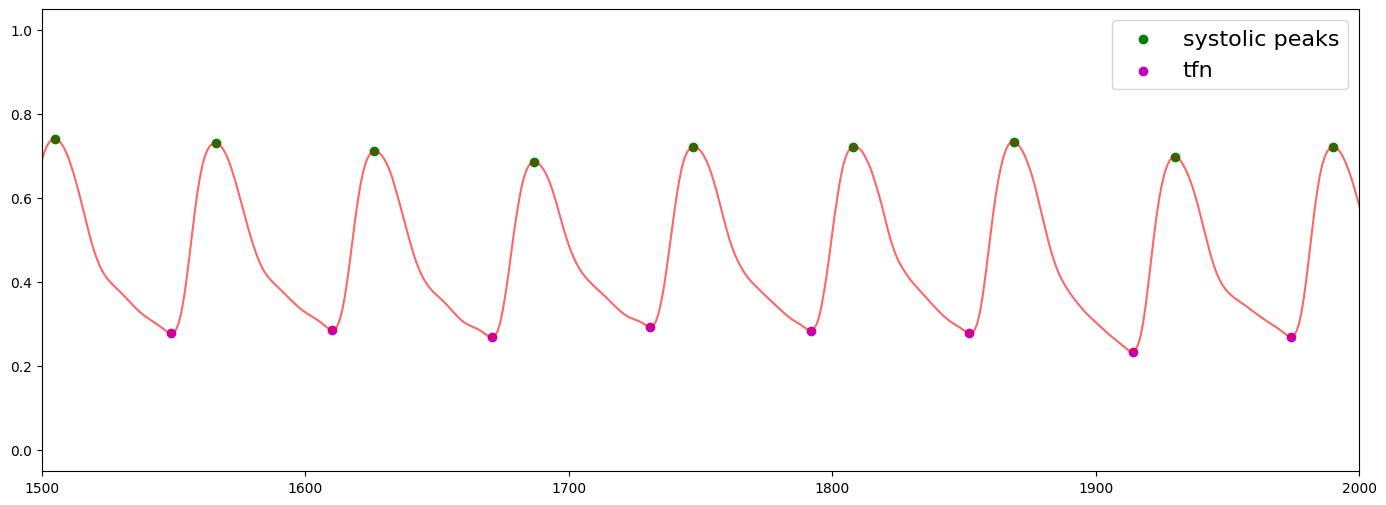

In [163]:
#画出极大值点和极小值点的图

systolics = systolic_peaks(ppg_signal_smoothed)
tfns = tfn_points(ppg_signal_smoothed)


plt.figure(figsize=(17,6))
plt.plot(ppg_signal_smoothed, c="r", alpha=0.6)

plt.scatter(systolics, ppg_signal_smoothed[systolics], c="g", label="systolic peaks")
plt.scatter(tfns, ppg_signal_smoothed[tfns], c="m", label="tfn")
plt.legend(prop={'size':16})
plt.xlim(1500,2000)

In [164]:
beats, systolics,ABP_matrix_List = beat_segmentation(ppg_signal_smoothed,ABP)

In [165]:
print(len(systolics))
print(len(beats))

1232
1232


## 血压提取

# 特征提取

找收缩点和舒张点


In [166]:
def dicrotic_notch(beat, systolic):
    '''Returns index of detected dicrotic notch in a beat. If not found returns 0'''
    
    derviative = np.diff(np.diff(beat[systolic:]))
    point = find_peaks(derviative)[0]
    corrected = 0
    
    if len(point) > 0:
        corrected =  systolic + point[-1]
        
    return corrected

def diastolic_peak(beat, systolic):
    '''Returns index of detected diastolic peak in a beat. If not found returns 0'''
   
    derviative = np.diff(np.diff(beat[systolic:]))
    point = find_peaks(derviative*(-1))[0]
    corrected = 0
    
    if len(point) > 0:
        corrected = systolic + point[-1]
        # 调控检测峰值
        if abs(beat[corrected]) >= abs(0.01*beat[corrected - 1]):
            return corrected
        else: return 0
        
    return corrected

In [167]:
def peaks_detection(beats, systolics):
    '''Returns created dataframe with beat values and critical points indices'''
    
    dicrotics = []
    diastolics = []
    
    for b, s in zip(beats, systolics):
        tnn = dicrotic_notch(b,s)
        tdn = diastolic_peak(b,s)
        
        dicrotics.append(tnn)
        diastolics.append(tdn)
    
    result = np.array([beats, systolics, dicrotics, diastolics], dtype=object)
    # remove those where dicrotics and diastolics weren't found
    result = result[..., result[2] > 0]
    result = result[..., result[3] > 0]
    
    # output shape is (4, nb) where nb is number of beats
    return result.T

In [168]:
beats_features = peaks_detection(beats, systolics)
print(beats_features.shape)

(1228, 4)


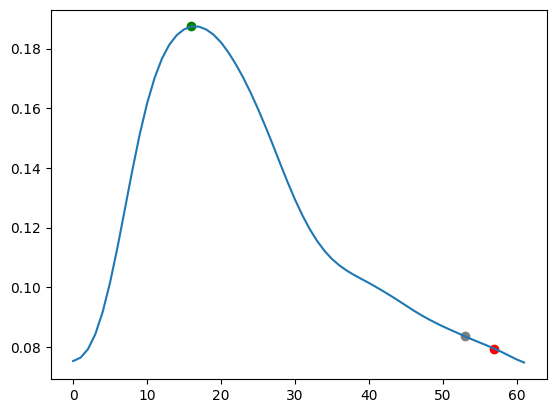

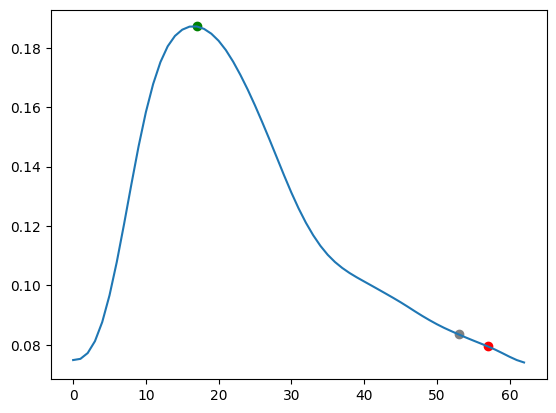

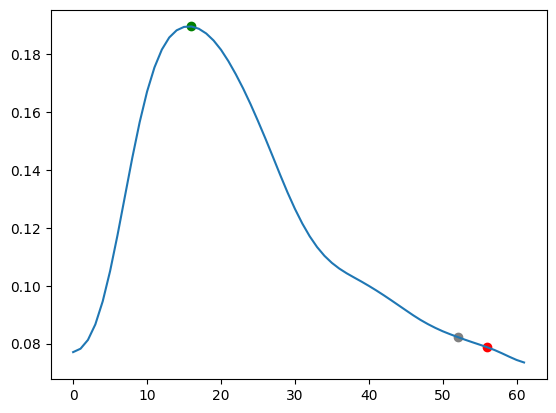

In [169]:
# 画出每个周期的收缩和舒张的极值点
for beat, systolic, dicrotic, diastolic in beats_features[:3]:
    plt.figure()
    plt.plot(beat)
    plt.scatter(systolic,beat[systolic], c="g")
    plt.scatter(diastolic,beat[diastolic], c= "r")
    plt.scatter(dicrotic,beat[dicrotic], c= "gray")
    plt.show()

In [170]:
#特征提取函数

def heart_rate(signal, fs):
    ''' Number of systolic peaks per minute. Normal between 60-100 bpm'''
    
    sys = systolic_peaks(signal)
    T = len(signal)/fs
    
    return len(sys)/(T/60)

def reflection_index(beat, systolic, diastolic):
    ''' Returns reflection index which is systolic amplitude to systolic-diastolic amplitude ratio'''
    
    a = beat[systolic] - np.min(beat)
    b = a - (beat[diastolic] - np.min(beat))
    
    return a/b

def systolic_timespan(dicrotic, fs):
    ''' Returns systolic beat timespan in seconds (dicrotic peak marks its end)'''
    
    return dicrotic/fs

def up_time(systolic, fs):
    ''' Returns time to systolic peak in seconds '''
    
    return systolic/fs
    
def systolic_volume(beat, dicrotic, fs):
    ''' Returns systolic volume as area under the curve '''
    
    return integrate.simps(beat[:dicrotic], dx=1/fs)
    
def diastolic_volume(beat, dicrotic, fs):
    ''' Returns diastolic volume as area under the curve '''
    
    return integrate.simps(beat[dicrotic:], dx=1/fs)

In [171]:
def extract_features(signal, beats_arr, fs):
    '''Extract features from beat array consisting of beat values, systolic peak index, dicrotic notch index and diastolic peak index'''
    
    features = []
    
    hr = heart_rate(signal, fs)
    
    for beat, systolic, dicrotic, diastolic in beats_arr:
        
        ri = reflection_index(beat, systolic, diastolic)
        st = systolic_timespan(dicrotic, fs)
        ut = up_time(systolic, fs)
        sv = systolic_volume(beat, dicrotic, fs)
        dv = diastolic_volume(beat, dicrotic, fs)

        features.append([hr, ri, st, ut, sv, dv])
    
    # return shape should be (Tx, 6)
    return np.array(features)

In [172]:
fs = 125
feature_list = extract_features(ppg_signal_smoothed, beats_features, fs)
feature_list.shape

(1228, 6)

获取每个周期的舒张压和收缩压

In [176]:

Blood_Pressure = []

for cycle_data in ABP_matrix_List:
    max_value = np.max(cycle_data)
    min_value = np.min(cycle_data)
    temp = [max_value,min_value]
    Blood_Pressure.append(temp)
   

temp = np.array(Blood_Pressure)
# 删除多余数据
Blood_Pressure_array = temp[:-4]
print(Blood_Pressure_array.shape)

(1228, 2)


In [184]:
total_len = len(feature_list)
train_size = 0.7*total_len
train_size = int(train_size)


X_train, X_test = feature_list[:train_size], feature_list[train_size:]
y_train, y_test = Blood_Pressure_array[:train_size], Blood_Pressure_array[train_size:]
print("训练集的大小是:"+str(train_size))
    

训练集的大小是:859


构建模型

In [180]:
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Add, Masking
from tensorflow.keras import Input, Model
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError

from keras.preprocessing.sequence import pad_sequences

把数据reshape成可以输入模型的格式

In [186]:
# X_trainpad = pad_sequences(X_train, maxlen=64, padding='post', dtype='float64')
# X_testpad = pad_sequences(X_test, maxlen=64, padding='post', dtype='float64')


X_trainpad = np.reshape(X_train, (1, train_size, 6))
X_testpad = np.reshape(X_test, (1, total_len-train_size, 6))
Y_trainpad = np.reshape(y_train, (1, train_size, 2))
Y_testpad = np.reshape(y_test, (1, total_len-train_size, 2))

In [187]:
print(f"X Input data shape: {X_train.shape}")
print(f"After padding X data shape: {np.array(X_trainpad).shape}")
print(f"y_train data shape: {y_train.shape}")

X Input data shape: (859, 6)
After padding X data shape: (1, 859, 6)
y_train data shape: (859, 2)


In [188]:
max_time = X_trainpad.shape[1]
n_features = 6

In [233]:
inputs = Input(shape=(max_time, n_features))

x = Masking(mask_value=0, input_shape=(max_time, n_features))(inputs)

x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(rate=0.5)(x)

x = LSTM(128, return_sequences=True)(x)
x = Dropout(rate=0.5)(x)

x_shortcut2 = LSTM(128, return_sequences=True)(x)
x_shortcut2 = Dropout(rate=0.5)(x_shortcut2)
x = Add()([x, x_shortcut2])

x_shortcut3 = LSTM(128, return_sequences=True)(x)
x_shortcut3 = Dropout(rate=0.5)(x_shortcut3)
x = Add()([x, x_shortcut3])

x = LSTM(128, return_sequences=False)(x)
x = Dropout(rate=0.5)(x)

# 我添加全连接层
x = Dense(876, activation='relu')(x)
x = Dropout(rate=0.2)(x)

x = Dense(256, activation='relu')(x)
outputs = Dense(units=2, activation='relu')(x)

model = Model(inputs, outputs)

In [234]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 859, 6)]             0         []                            
                                                                                                  
 masking_4 (Masking)         (None, 859, 6)               0         ['input_5[0][0]']             
                                                                                                  
 bidirectional_4 (Bidirecti  (None, 859, 256)             138240    ['masking_4[0][0]']           
 onal)                                                                                            
                                                                                                  
 dropout_20 (Dropout)        (None, 859, 256)             0         ['bidirectional_4[0][0]'

In [235]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.01)

model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=[RootMeanSquaredError()])

In [236]:
history = model.fit(X_trainpad, Y_trainpad, batch_size=1000, epochs=100)

Epoch 1/100
1/1 [==============================] - 26s 26s/step - loss: 101.8841 - root_mean_squared_error: 106.2697
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 97.0729 - root_mean_squared_error: 101.5236
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 79.9819 - root_mean_squared_error: 84.6221
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 36.8461 - root_mean_squared_error: 43.8377
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 29.9111 - root_mean_squared_error: 35.5579
Epoch 6/100


In [208]:
# make predictions
train_predict = model.predict(X_trainpad)
test_predict = model.predict(X_testpad)

1/1 [==============================] - 8s 8s/step


Text(0.5, 0, 'Epoch')

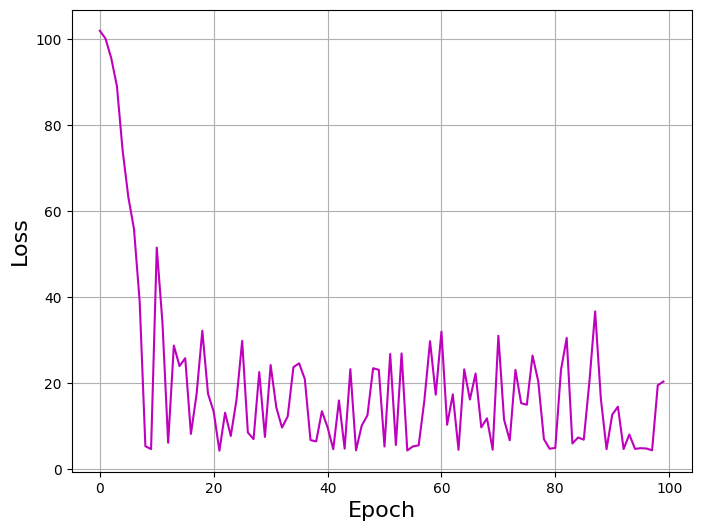

In [232]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], c='m')
plt.grid()
plt.ylabel('Loss',fontsize=16)
plt.xlabel('Epoch', fontsize=16)

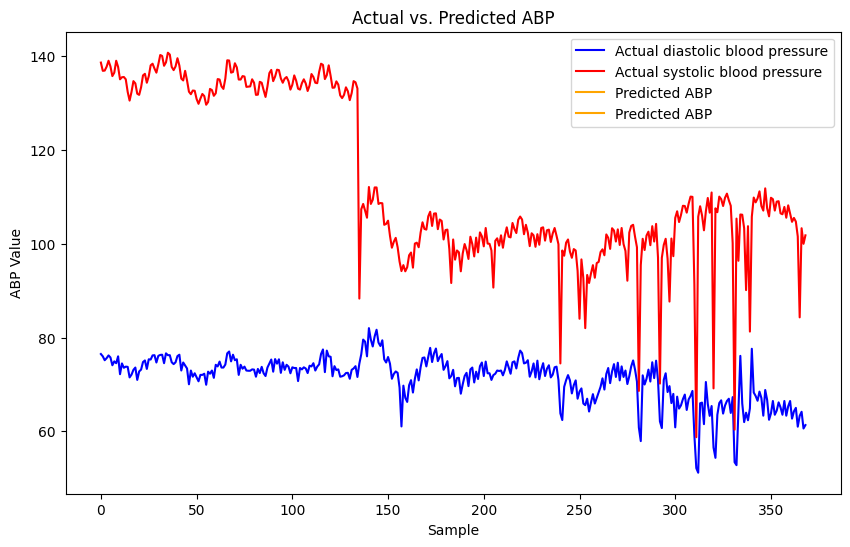

In [212]:
# 计算均方根误差 (RMSE)
# rmse = np.sqrt(mean_squared_error(y_test, test_predict))

# 打印RMSE
# print("Root Mean Squared Error (RMSE):", rmse)

# 绘制实际值与预测值的对比图
plt.figure(figsize=(10, 6))
plt.plot(y_test[:,1], label='Actual diastolic blood pressure', color='blue')
plt.plot(y_test[:,0], label='Actual systolic blood pressure', color='red')
plt.plot(test_predict, label='Predicted ABP', color='orange')
plt.title('Actual vs. Predicted ABP')
plt.xlabel('Sample')
plt.ylabel('ABP Value')
plt.legend()
plt.show()